# Deep Convolutional GANs

Brief introduction to Deep Convolutional Generative Adversarial Networks or DCGANs. This notebook is organized as follows:

1. **Research Paper**
1. **Background**
2. **Definition**
3. **Training DCGANs with CIFAR-10 dataset, Keras and TensorFlow**

---

## 1. Research Paper

* [Unsupervised Representation Learning With Deep Convolutional](https://arxiv.org/pdf/1511.06434.pdf)

## 2. Background

Brief definition of some concepts, such as convolution and Convolutional Neural Network (CNN) and GANs.

### Convolution

Convolution is a mathematical operation which describes a rule of how to mix two functions or pieces of information.

* Features Map $I$
* Convolution kernel $K$
* Map of transformed features $S(i, j)$

![convolution](https://devblogs.nvidia.com/wp-content/uploads/2015/11/convolution.png)

### Convolutional Neural Network (CNN)

Convolutional networks are simply neural networks that use convolution in place of general matrix multiplication in at least one of their layers.

These convolutional layers have parameters that are learned so that these filters are adjusted automatically to extract the most useful information for the task at hand.

* Input is a multidimensional array of data,
* Kernel is a multidimensional array of parameters,
* These multidimensional arrays are tensors.

#### Layers CNN

* Convolution: extract features from imagem.
* Pooling: reduce dimension of entry.
* Dense / Fully connected: connect the layers.

### GANs

**Generative adversarial nets** consists of two models: a generative model $G$ that captures the data distribution, and a discriminative model $D$ that estimates the probability that a sample came from the training data rather than $G$.

The generator distribution $p_g$ over data data $x$, the generator builds a mapping function from a prior noise distribution $p_z(z)$ to data space as $G(z;\theta_g)$.

The discriminator, $D(x;\theta_d)$, outputs a single scalar representing the probability that $x$ came form training data rather than $p_g$.

The **cost function** $V(G,D)$:

$$ \underset{G}{min} \: \underset{D}{max} \; V_{GAN}(D,G) = \mathbb{E}_{x\sim p_{data}(x)}[log D(x)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1 - D(G(z)))]$$

## 3. Definition

The difference between the simple GAN and the DCGAN, is the generator of the simple GAN is a simple fully connected network. The generator of the DCGAN uses the transposed convolution (Fractionally-strided convolution or 
Deconvolution) technique to perform up-sampling of 2D image size.

DCGAN are mainly composes of convolution layers without max pooling or fully connected layers. It uses convolutional stride and transposed convolution for the downsampling and the upsampling. 

### Network Design

<img src="../../img/network_design_dcgan.png" width="600"> 


### Cost Funcion


$$ \underset{G}{min} \: \underset{D}{max} \; V_{DCGAN}(D,G) = \mathbb{E}_{x\sim p_{data}(x)}[log D(x)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1 - D(G(z)))]$$

> * Replace all max pooling with convolutional stride.
    Use transposed convolution for upsampling.
    Eliminate fully connected layers.
    Use Batch normalization except the output layer for the generator and the input layer of the discriminator.
    Use ReLU in the generator except for the output which uses tanh.
    Use LeakyReLU in the discriminator.*



## 4. Training DCGANs with CIFAR-10 dataset, Keras and TensorFlow

A DCGANs implementation using the transposed convolution technique and the [Keras](https://keras.io/) library.

* **Data**
    * Rescale the CIFAR-10 images to be between -1 and 1.
    
* **Generator**
    * Use the **inverse of convolution**, called transposed convolution.
    * **ReLU activation** and **BatchNormalization**.
    * The input to the generator is the **normal distribution** $z$ or latent sample (100 values).
    * The last activation is **tanh**.
    
* **Discriminator**
    * Use the **Convolutional neural network**.
    * **LeakyReLU activation** and **BatchNormalization**.
    * The last activation is **sigmoid**.
    
* **Loss**
    * binary_crossentropy

* **Optimizer**
    * Adam(lr=0.0003, beta_1=0.5)

* batch_size = 64
* epochs = 100


### 1. Load data

#### Load libraries

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


#### Getting the data

In [23]:
# load dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()


#### Explore visual data

The CIFAR-10 images are RGB with 10 classes

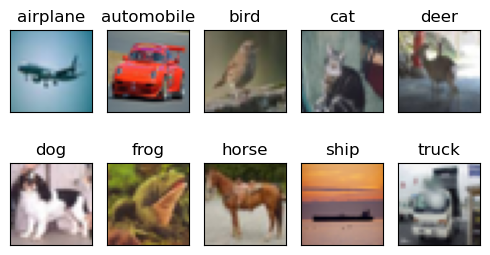

In [24]:
WIDTH_SIZE = 5
HEIGHT_SIZE = 3

num_classes = len(np.unique(y_train))
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(WIDTH_SIZE, HEIGHT_SIZE))
for i in range(num_classes):
    ax = plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = X_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    img = features_idx[img_num,::]
    ax.set_title(class_names[i])
    plt.imshow(img)
    
plt.tight_layout()


#### Reshaping and normalizing the inputs

In [25]:
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')


X_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [26]:
if tf.keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 3, 32, 32)
    X_test = X_test.reshape(X_test.shape[0], 3, 32, 32)
    input_shape = (3, 32, 32)
else:
    X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
    X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
    input_shape = (32, 32, 3)
    
# convert class vectors to binary class matrices
Y_train = tf.keras.utils.to_categorical(y_train, num_classes)
Y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# the generator is using tanh activation, for which we need to preprocess 
# the image data into the range between -1 and 1.

X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

X_test = np.float32(X_test)
X_test = (X_test / 255 - 0.5) * 2
X_test = np.clip(X_test, -1, 1)

print('X_train reshape:', X_train.shape)
print('X_test reshape:', X_test.shape)


X_train reshape: (50000, 32, 32, 3)
X_test reshape: (10000, 32, 32, 3)


### 2. Define model

#### Generator

In [27]:
# latent space dimension
latent_dim = 100

# Generator network
generator = tf.keras.models.Sequential()

generator.add(
    tf.keras.layers.Dense(
        2 * 2 * 512, use_bias=False, input_shape=(latent_dim,)
    )
)
generator.add(tf.keras.layers.BatchNormalization())
generator.add(tf.keras.layers.LeakyReLU())
generator.add(tf.keras.layers.Reshape((2, 2, 512)))

generator.add(
    tf.keras.layers.Conv2DTranspose(
        256, kernel_size=5, strides=2, padding="same", use_bias=False
    )
)
generator.add(tf.keras.layers.BatchNormalization())
generator.add(tf.keras.layers.LeakyReLU())

generator.add(
    tf.keras.layers.Conv2DTranspose(
        128, kernel_size=5, strides=2, padding="same", use_bias=False
    )
)
generator.add(tf.keras.layers.BatchNormalization())
generator.add(tf.keras.layers.LeakyReLU())

generator.add(
    tf.keras.layers.Conv2DTranspose(
        64, kernel_size=5, strides=2, padding="same", use_bias=False
    )
)
generator.add(tf.keras.layers.BatchNormalization())
generator.add(tf.keras.layers.LeakyReLU())

generator.add(
    tf.keras.layers.Conv2DTranspose(
        3,
        kernel_size=5,
        strides=2,
        padding="same",
        use_bias=False,
        activation="tanh",
    )
)


#### Generator model visualization

In [28]:
# prints a summary representation of your model
generator.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 2048)              204800    
                                                                 
 batch_normalization_7 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 2048)              0         
                                                                 
 reshape_2 (Reshape)         (None, 2, 2, 512)         0         
                                                                 
 conv2d_transpose_7 (Conv2DT  (None, 4, 4, 256)        3276800   
 ranspose)                                                       
                                                                 
 batch_normalization_8 (Batc  (None, 4, 4, 256)       

#### Discriminator


In [29]:
# imagem shape 32x32x3
img_shape = X_train[0].shape

# Discriminator network
discriminator = tf.keras.models.Sequential()

discriminator.add(
    tf.keras.layers.Conv2D(
        64, kernel_size=5, strides=2, padding="same", input_shape=(img_shape)
    )
)
discriminator.add(tf.keras.layers.LeakyReLU())
discriminator.add(tf.keras.layers.Dropout(0.3))

discriminator.add(
    tf.keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same")
)
discriminator.add(tf.keras.layers.LeakyReLU())
discriminator.add(tf.keras.layers.Dropout(0.3))

discriminator.add(
    tf.keras.layers.Conv2D(256, kernel_size=5, strides=2, padding="same")
)
discriminator.add(tf.keras.layers.LeakyReLU())
discriminator.add(tf.keras.layers.Dropout(0.3))

discriminator.add(
    tf.keras.layers.Conv2D(512, kernel_size=5, strides=2, padding="same")
)
discriminator.add(tf.keras.layers.LeakyReLU())
discriminator.add(tf.keras.layers.Dropout(0.3))

discriminator.add(tf.keras.layers.Flatten())

discriminator.add(tf.keras.layers.Dense(1, activation="sigmoid"))


#### Discriminator model visualization

In [30]:
# prints a summary representation of your model
discriminator.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                                 
 dropout_6 (Dropout)         (None, 16, 16, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 dropout_7 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 256)        

### 3. Compile model

#### Compile discriminator

In [31]:
# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003, beta_1=0.5)

discriminator.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["binary_accuracy"],
)



#### Combined network

We connect the generator and the discriminator to make a DCGAN.

In [32]:
discriminator.trainable = False

z = tf.keras.layers.Input(shape=(latent_dim,))
img = generator(z)
decision = discriminator(img)
d_g = tf.keras.models.Model(inputs=z, outputs=decision)

d_g.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["binary_accuracy"],
)


#### GAN model vizualization

In [33]:
# prints a summary representation of your model
d_g.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_4 (Sequential)   (None, 32, 32, 3)         4520384   
                                                                 
 sequential_5 (Sequential)   (None, 1)                 4308609   
                                                                 
Total params: 8,828,993
Trainable params: 4,515,392
Non-trainable params: 4,313,601
_________________________________________________________________


### 4. Fit model


epoch = 1/150, d_loss=0.236, g_loss=0.893                                                                                                                        
1/1 [==============================] - 0s 139ms/step


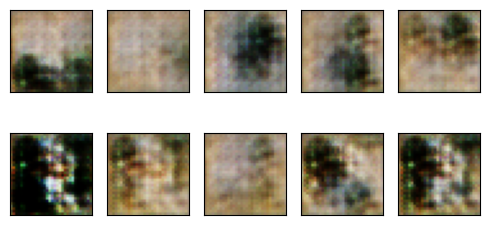

epoch = 2/150, d_loss=0.363, g_loss=2.256                                                                                                                         
epoch = 3/150, d_loss=0.394, g_loss=4.888                                                                                                                         
epoch = 4/150, d_loss=0.362, g_loss=3.673                                                                                                                        
epoch = 5/150, d_loss=0.365, g_loss=2.562                                                                                                                        
epoch = 6/150, d_loss=0.353, g_loss=3.011                                                                                                                        
epoch = 7/150, d_loss=0.453, g_loss=2.256                                                                                                                        
epoch = 8/150, d_loss=0.38

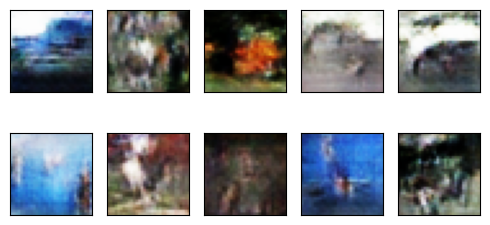

epoch = 12/150, d_loss=0.459, g_loss=2.275                                                                                                                        
epoch = 13/150, d_loss=0.500, g_loss=2.261                                                                                                                        
epoch = 14/150, d_loss=0.483, g_loss=2.556                                                                                                                        
epoch = 15/150, d_loss=0.544, g_loss=1.822                                                                                                                        
epoch = 16/150, d_loss=0.625, g_loss=2.131                                                                                                                        
epoch = 17/150, d_loss=0.560, g_loss=1.709                                                                                                                        
epoch = 18/150, d_loss

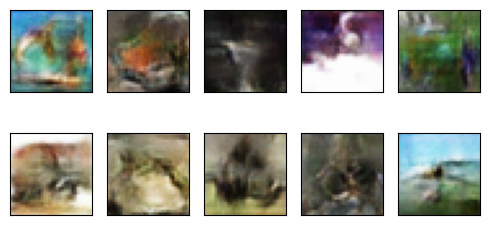

epoch = 22/150, d_loss=0.494, g_loss=1.720                                                                                                                        
epoch = 23/150, d_loss=0.583, g_loss=1.688                                                                                                                        
epoch = 24/150, d_loss=0.574, g_loss=1.787                                                                                                                        
epoch = 25/150, d_loss=0.523, g_loss=1.703                                                                                                                        
epoch = 26/150, d_loss=0.537, g_loss=1.859                                                                                                                        
epoch = 27/150, d_loss=0.551, g_loss=1.874                                                                                                                        
epoch = 28/150, d_loss

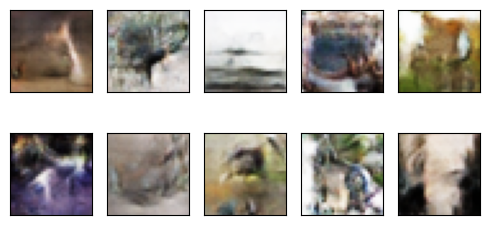

epoch = 32/150, d_loss=0.466, g_loss=1.691                                                                                                                        
epoch = 33/150, d_loss=0.514, g_loss=1.592                                                                                                                        
epoch = 34/150, d_loss=0.582, g_loss=1.497                                                                                                                        
epoch = 35/150, d_loss=0.592, g_loss=1.575                                                                                                                        
epoch = 36/150, d_loss=1.226, g_loss=1.310                                                                                                                        
epoch = 37/150, d_loss=0.630, g_loss=1.687                                                                                                                        
epoch = 38/150, d_loss

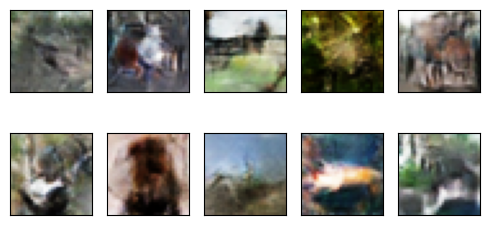

epoch = 42/150, d_loss=0.574, g_loss=1.879                                                                                                                        
epoch = 43/150, d_loss=0.549, g_loss=1.633                                                                                                                        
epoch = 44/150, d_loss=0.596, g_loss=1.484                                                                                                                        
epoch = 45/150, d_loss=0.462, g_loss=2.229                                                                                                                        
epoch = 46/150, d_loss=0.548, g_loss=2.359                                                                                                                        
epoch = 47/150, d_loss=0.511, g_loss=1.866                                                                                                                        
epoch = 48/150, d_loss

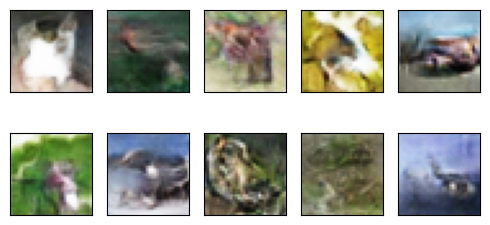

epoch = 52/150, d_loss=0.458, g_loss=1.827                                                                                                                        
epoch = 53/150, d_loss=0.571, g_loss=1.990                                                                                                                        
epoch = 54/150, d_loss=0.477, g_loss=1.857                                                                                                                        
epoch = 55/150, d_loss=0.545, g_loss=1.671                                                                                                                        
epoch = 56/150, d_loss=0.603, g_loss=1.477                                                                                                                        
epoch = 57/150, d_loss=0.560, g_loss=3.264                                                                                                                        
epoch = 58/150, d_loss

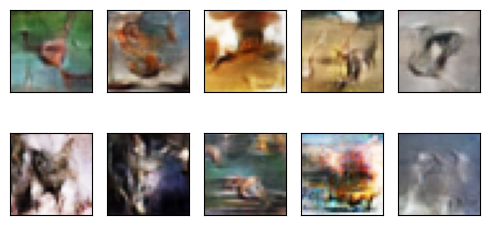

epoch = 62/150, d_loss=0.577, g_loss=1.530                                                                                                                        
epoch = 63/150, d_loss=0.583, g_loss=2.843                                                                                                                        
epoch = 64/150, d_loss=0.546, g_loss=2.340                                                                                                                        
epoch = 65/150, d_loss=0.629, g_loss=1.596                                                                                                                        
epoch = 66/150, d_loss=0.546, g_loss=1.806                                                                                                                        
epoch = 67/150, d_loss=0.609, g_loss=2.064                                                                                                                        
epoch = 68/150, d_loss

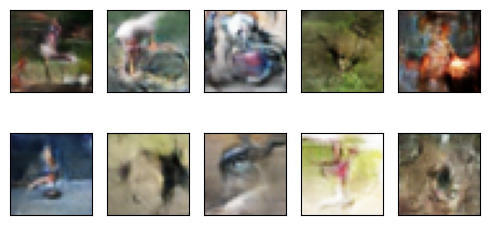

epoch = 72/150, d_loss=0.521, g_loss=2.086                                                                                                                        
epoch = 73/150, d_loss=0.556, g_loss=1.820                                                                                                                        
epoch = 74/150, d_loss=0.572, g_loss=1.534                                                                                                                        
epoch = 75/150, d_loss=0.556, g_loss=1.609                                                                                                                        
epoch = 76/150, d_loss=0.536, g_loss=1.977                                                                                                                        
epoch = 77/150, d_loss=0.471, g_loss=2.284                                                                                                                        
epoch = 78/150, d_loss

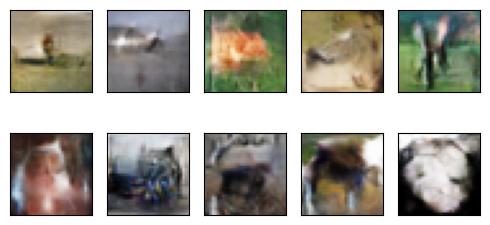

epoch = 82/150, d_loss=0.500, g_loss=1.728                                                                                                                        
epoch = 83/150, d_loss=0.513, g_loss=2.025                                                                                                                        
epoch = 84/150, d_loss=0.466, g_loss=1.672                                                                                                                        
epoch = 85/150, d_loss=0.509, g_loss=2.063                                                                                                                        
epoch = 86/150, d_loss=0.597, g_loss=2.032                                                                                                                        
epoch = 87/150, d_loss=0.571, g_loss=2.327                                                                                                                        
epoch = 88/150, d_loss

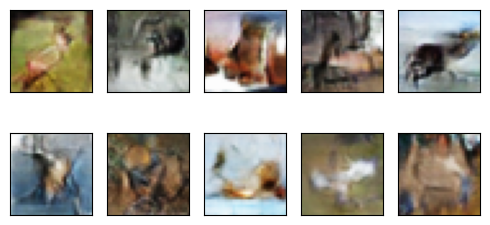

epoch = 92/150, d_loss=0.510, g_loss=2.382                                                                                                                        
epoch = 93/150, d_loss=0.492, g_loss=2.120                                                                                                                        
epoch = 94/150, d_loss=0.504, g_loss=1.667                                                                                                                        
epoch = 95/150, d_loss=0.508, g_loss=2.314                                                                                                                        
epoch = 96/150, d_loss=0.525, g_loss=1.795                                                                                                                        
epoch = 97/150, d_loss=0.550, g_loss=2.349                                                                                                                        
epoch = 98/150, d_loss

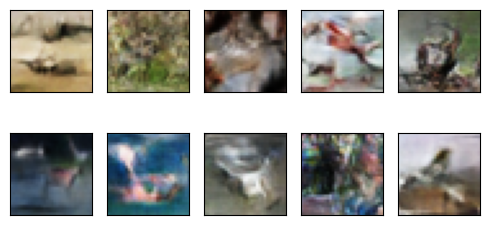

epoch = 102/150, d_loss=0.548, g_loss=1.780                                                                                                                        
epoch = 103/150, d_loss=0.541, g_loss=2.148                                                                                                                        
epoch = 104/150, d_loss=0.508, g_loss=1.582                                                                                                                        
epoch = 105/150, d_loss=0.580, g_loss=1.782                                                                                                                        
epoch = 106/150, d_loss=0.666, g_loss=2.209                                                                                                                        
epoch = 107/150, d_loss=0.472, g_loss=1.814                                                                                                                        
epoch = 108/150,

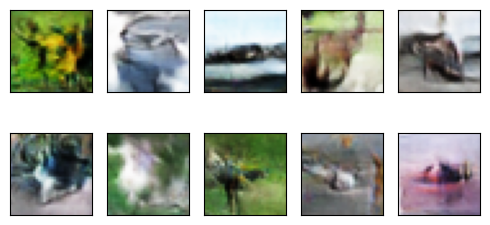

epoch = 112/150, d_loss=0.621, g_loss=1.599                                                                                                                        
epoch = 113/150, d_loss=0.444, g_loss=2.115                                                                                                                        
epoch = 114/150, d_loss=0.504, g_loss=2.313                                                                                                                        
epoch = 115/150, d_loss=0.561, g_loss=1.744                                                                                                                        
epoch = 116/150, d_loss=0.483, g_loss=2.304                                                                                                                        
epoch = 117/150, d_loss=0.444, g_loss=2.103                                                                                                                        
epoch = 118/150,

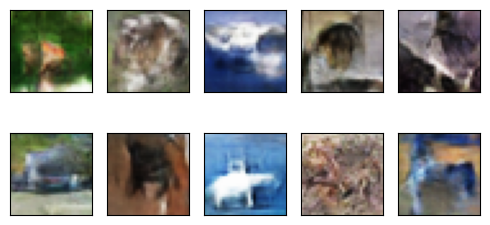

epoch = 122/150, d_loss=0.649, g_loss=2.328                                                                                                                        
epoch = 123/150, d_loss=0.454, g_loss=1.867                                                                                                                        
epoch = 124/150, d_loss=0.499, g_loss=2.378                                                                                                                        
epoch = 125/150, d_loss=0.724, g_loss=2.015                                                                                                                        
epoch = 126/150, d_loss=0.466, g_loss=2.159                                                                                                                        
epoch = 127/150, d_loss=0.531, g_loss=2.103                                                                                                                        
epoch = 128/150,

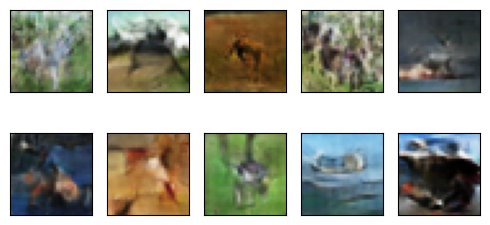

epoch = 132/150, d_loss=0.454, g_loss=2.974                                                                                                                        
epoch = 133/150, d_loss=0.512, g_loss=2.036                                                                                                                        
epoch = 134/150, d_loss=0.443, g_loss=1.807                                                                                                                        
epoch = 135/150, d_loss=0.499, g_loss=2.078                                                                                                                        
epoch = 136/150, d_loss=0.470, g_loss=2.762                                                                                                                        
epoch = 137/150, d_loss=0.518, g_loss=2.007                                                                                                                        
epoch = 138/150,

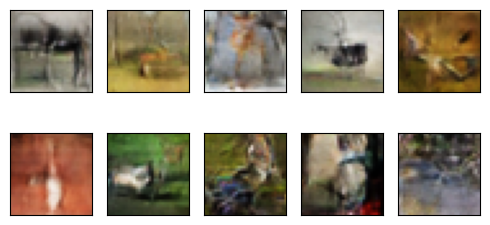

epoch = 142/150, d_loss=0.542, g_loss=1.648                                                                                                                        
epoch = 143/150, d_loss=0.517, g_loss=2.212                                                                                                                        
epoch = 144/150, d_loss=0.485, g_loss=1.720                                                                                                                        
epoch = 145/150, d_loss=0.482, g_loss=2.351                                                                                                                        
epoch = 146/150, d_loss=0.534, g_loss=1.765                                                                                                                        
epoch = 147/150, d_loss=0.492, g_loss=2.076                                                                                                                        
epoch = 148/150,

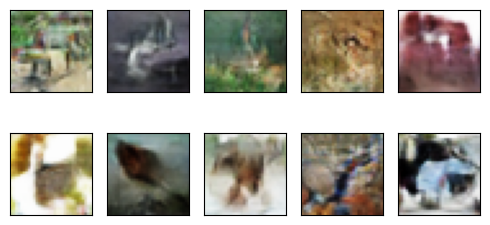

In [34]:
epochs = 150
batch_size = 32
smooth = 0.1

real = tf.ones(shape=(batch_size, 1))
fake = tf.zeros(shape=(batch_size, 1))

d_loss = []
g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):

        # Train Discriminator weights
        discriminator.trainable = True

        # Real samples
        X_batch = X_train[i * batch_size : (i + 1) * batch_size]
        d_loss_real = discriminator.train_on_batch(
            x=X_batch, y=real * (1 - smooth)
        )

        # Fake Samples
        z = tf.random.normal(shape=(batch_size, latent_dim), mean=0, stddev=1)
        X_fake = generator.predict_on_batch(z)
        d_loss_fake = discriminator.train_on_batch(x=X_fake, y=fake)

        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])

        # Train Generator weights
        discriminator.trainable = False

        z = tf.random.normal(shape=(batch_size, latent_dim), mean=0, stddev=1)
        g_loss_batch = d_g.train_on_batch(x=z, y=real)

        print(
            "epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f"
            % (
                e + 1,
                epochs,
                i,
                len(X_train) // batch_size,
                d_loss_batch,
                g_loss_batch[0],
            ),
            100 * " ",
            end="\r",
        )

    d_loss.append(d_loss_batch)
    g_loss.append(g_loss_batch[0])

    print(
        "epoch = %d/%d, d_loss=%.3f, g_loss=%.3f"
        % (e + 1, epochs, d_loss[-1], g_loss[-1]),
        100 * " ",
    )

    if e % 10 == 0:
        samples = 10

        z = tf.random.normal(shape=(samples, latent_dim), mean=0, stddev=1)
        x_fake = generator.predict(z)

        fig = plt.figure(figsize=(WIDTH_SIZE, HEIGHT_SIZE))
        for k in range(samples):
            plt.subplot(2, 5, k + 1, xticks=[], yticks=[])
            plt.imshow(((x_fake[k] + 1) * 127).astype(np.uint8))

        plt.tight_layout()
        plt.show()


### 5. Evaluate model

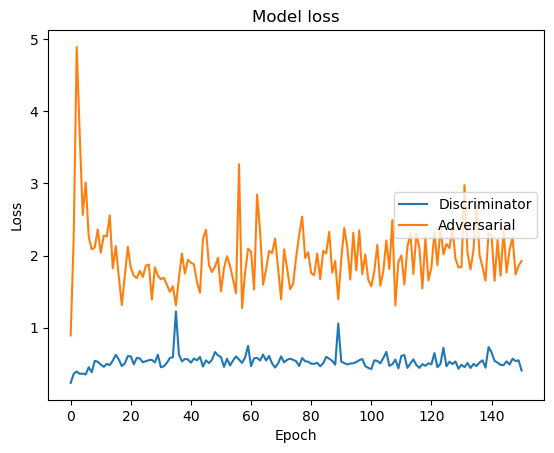

In [35]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()


## References

* [Convolution](https://devblogs.nvidia.com/deep-learning-nutshell-core-concepts/)
* [GAN — DCGAN (Deep convolutional generative adversarial networks)](https://medium.com/@jonathan_hui/gan-dcgan-deep-convolutional-generative-adversarial-networks-df855c438f)